<a href="https://colab.research.google.com/github/jehasbani/credit-card-fraud-detection/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection

## Introduction

Online transactions have become a crucial part of any business over the years. Many of those transactions use credit cards as the main form of payment, and any e-commerce business should be able to protect themselves against fraudulent transactions because such an issue may cost them a lot of money and may have an everlasting impact to the company's reputation.

Many of the fraud detection techniques are rule based and may be simple or more complex, but this approach is susceptible to breach if a clever enough scammer gets to work.


## Case Study

In this project we'll use a public credit card transaction dataset that has been anonymized and try a deep learning based approach to create a credit card fraud detection model in order to safeguard an e-commerce business from such dangers.

The challenge posed by this project lies in the fact that most of the transactions will not be fraudulent. This means that the dataset will be heavily imbalanced and maybe a +98% accuracy will not mean that we have a good model at hand. To address this issue we'll rely on resampling, class weighting and properly defined performance metrics to ensure we are training the model correctly. 

It's estimated that only 0.1% of business transactions are fraudulent, but even that small proportion costs over $9 billion a year to businesses! 


## Setup

Importing libraries and uploading the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tempfile

import tensorflow as tf
from tensorflow import keras

import sklearn
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score, roc_auc_score, auc

np.random.seed(2)

In [ ]:
#mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

font = {'size': 10}
plt.rc('font', **font)

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')

You can also get the data from Kaggle's [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) site.

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As we can see, the data available is encoded to protect the users' privacy. We have the columns V1-V28 that contain encoded user information such as location, financial information, and more protected data. We also have the columns Time, Amount and Class which are self-explanatory.

## Exploratory Data Analysis

Checking for nulls and odd data types

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Basic statistic overview of the data

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Checking the class imbalance

In [ ]:
neg, pos = np.bincount(df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



As we can see, the columns v1 to v28 have mean = 0 and std = 1. The `Amount` column could be standardized later on, and the target variable `Class` has a mean of 0.0017 which shows the considerable imbalance present. 

### Histograms

In [ ]:
df_numerical = df.drop(columns = ['Class'])

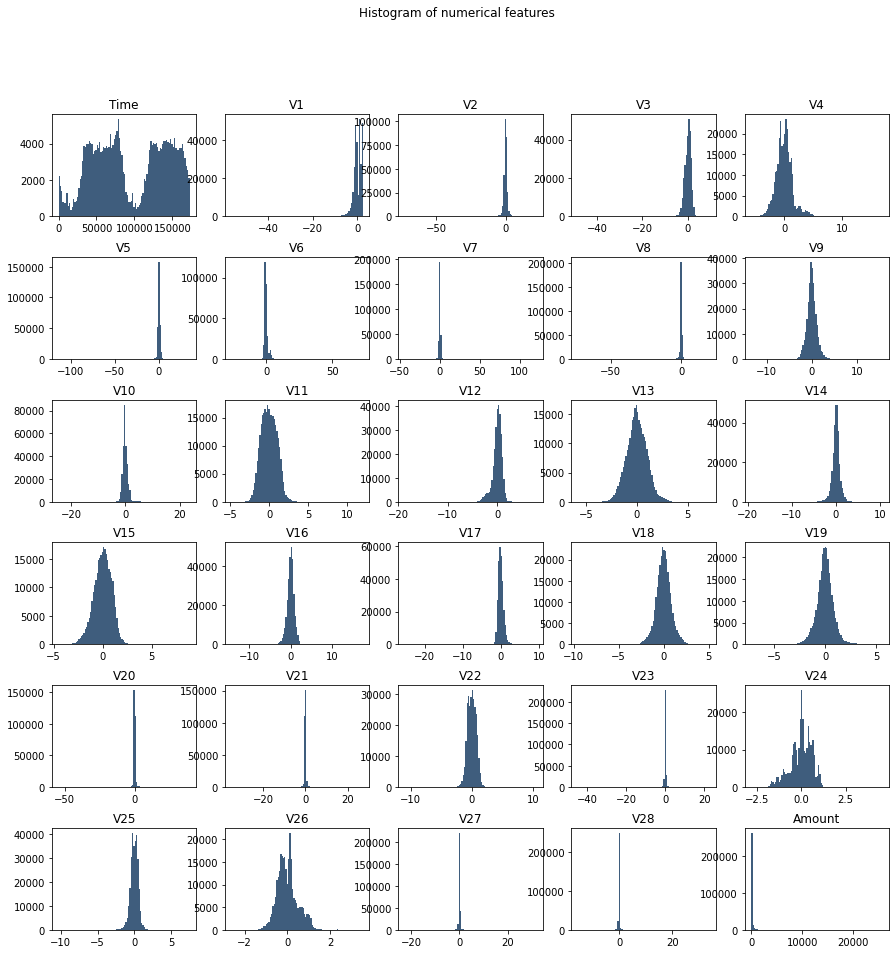

In [ ]:
fig,axes = plt.subplots(6,5, figsize=(15,15))

axes = axes.ravel()
for ax in axes:
  ax.set_axis_off()

plt.suptitle('Histogram of numerical features')
for i,col in enumerate(df_numerical.columns):
  axes[i].set_title(col)

  vals = np.size(df_numerical[col].unique())
  #put a limit to vals to make sure that there are no more than 100 bins (for computing efficiency)
  if vals >= 100:
    vals = 100
  
  axes[i].hist(df_numerical[col].values, bins = vals, color = '#3f5d7d')
  axes[i].set_axis_on()

plt.subplots_adjust(hspace=0.4)
plt.show()

From this overview plot we see that the distributions follow a normal distribution overall. The `Amount` columns covers a large range and should be log transformed, as well as standardized.

---
### Correlation with target plot

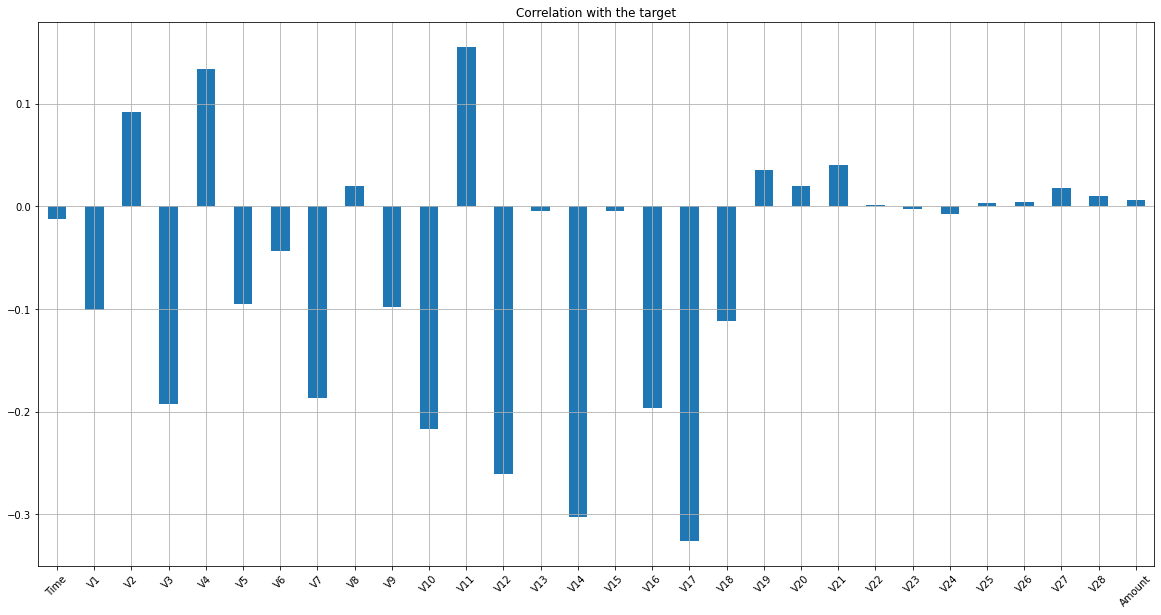

In [ ]:
df_numerical.corrwith(df.Class).plot.bar(
    figsize=(20,10),
    title='Correlation with the target',
    fontsize=15,
    rot=45,
    grid=True
)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

The constraints of the correlations values are approximately -0.3 and 0.2 which, in terms of correlation weight, are not very high values. We can clearly see that there is not a strong correlation between any of the variables and the target.

---
### Correlation Matrix

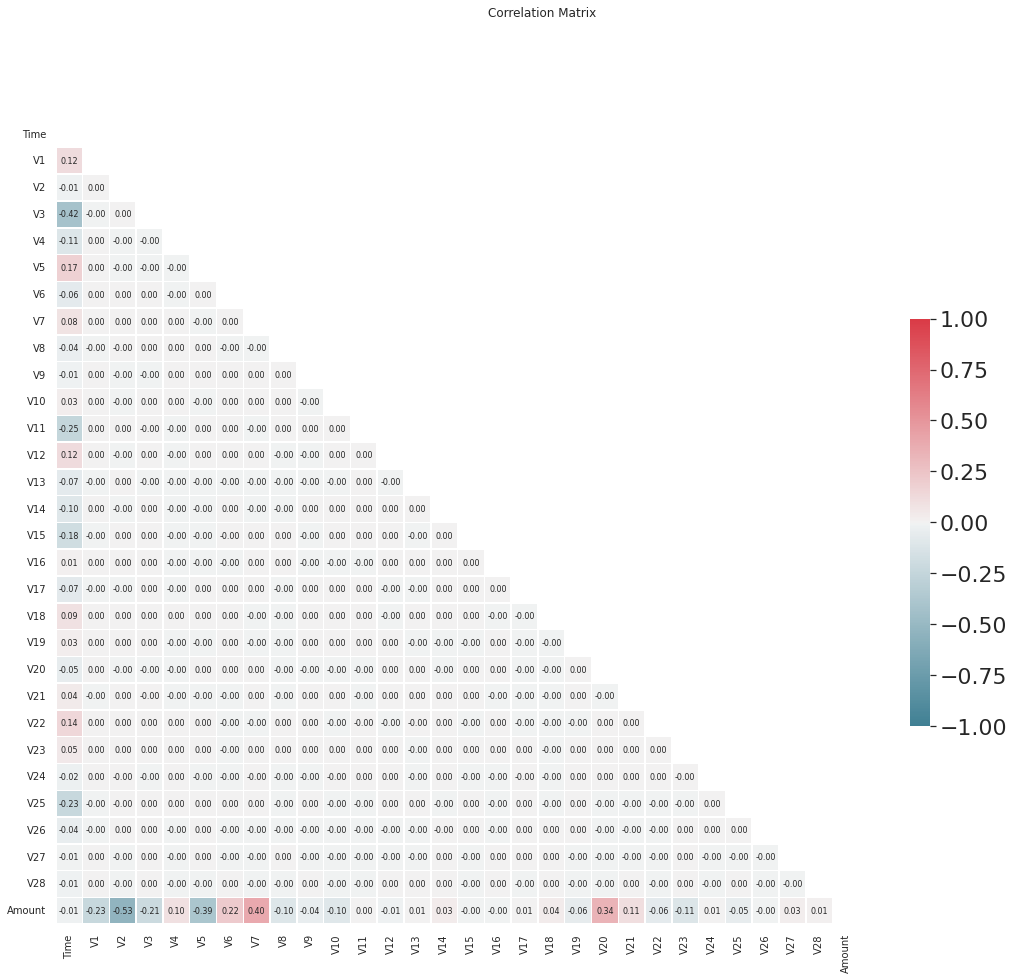

In [ ]:
corr = df_numerical.corr() 
sns.set(style='white',font_scale=2)

# generate a mask for the upper triangle
mask = np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize = (18,15))
f.suptitle("Correlation Matrix", fontsize=12)

# generate a colormap
cmap = sns.diverging_palette(220,10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio

sns.heatmap(corr,
            mask=mask,
            cmap=cmap, 
            vmax=1, vmin = -1, 
            center=0, 
            square=True, 
            linewidths=0.5, 
            cbar_kws={"shrink":0.5},
            annot=True,
            annot_kws={"fontsize":8},
            fmt='.2f')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

There is also no correlation between the features.

--- 

## Data Preprocessing

In [ ]:
y = df.Class
X = df.drop(columns = ['Class','Time'])

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
X['Log Ammount'] = np.log(X.pop('Amount')+eps)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.3,random_state=0)

### Standard Scaler

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
X_train = np.clip(X_train, -5, 5)
X_val = np.clip(X_val, -5, 5)
X_test = np.clip(X_test, -5, 5)

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

## Baseline Model



Let's begin building the classification model. I'll try out a basic neural network to perform the task at hand. In this section I'll train the network without addressing the class imbalance.

### Metrics

A model performs as well as the metrics we choose to evaluate it with. If we select the wrong metrics we could end up with a false perception of high performance. In this particular example, due to the class imbalance, we need to carefully choose the metrics we are going to use to evaluate the model

These are a few metrics computed by the model that will be helpful when evaluating the performance.


*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$

>   Note: Accuracy is not a helpful metric for this task. You can have a 99.8% accuracy on this task by predicting 8 all the time.  

*   **Precision** is the percentage of **predicted** positives that were correctly classified. Summarizes the fraction of examples assigned to the positive class that belong to the positive class.
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$

*   **Recall** is the percentage of **actual** positives that were correctly classified. Also known as **Sensitivity**, summarizes how well the positive class was predicted.
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$

*   **Specificity** is the percentage of **actual** negatives that were correctly classified. Summarises how well the negative class was predicted.
>   $\frac{\text{true negatives}}{\text{true negatives + false positives}}$

> Note: For imbalanced classification, the sensitivity might be more interesting than the specificity.


*   **F-Score**: combines **Precision** and **Recall** into a single metric
>   $\frac{2 * precision * recall}{precision + recall}$

>   The F-Score is a popular metric for imbalanced classification.

*   **F$_{\beta}$-Score** is an abstraction of the **F-Score** where the balance of precision and recall in the calculation of the harmonic mean is controlled by a coefficient called beta.
>   $\frac{(1+\beta^2) * precision * recall}{\beta^2*precision + recall}$

> The way to decide which F-Score to use is:
   * If FP and FP cost the same: F-Score
   * If FP are more costly: F$_{0.5}$-Score
   * If FN are more costly: F$_{2}$-Score
   
> Since in this case False Negatives impact on the business harder than False Positives, we choose F$_{2}$-Score

*   **ROC AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample. Although generally effective, the ROC Curve and ROC AUC can be optimistic under a severe class imbalance.
*   **AUPRC** refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds. In this case, the focus on the minority class makes the Precision-Recall AUC more useful for imbalanced classification problems.

Thanks to this introduction we can then select the following metrics to evaluate our model for this problem:

* Precision
* Recall
* F$_2$-Score
* PR Curve and AUC Score

We'll also plot the ROC Curve and compute the AUC to compare the difference we get and see how our perception of the perfomance of the model would be misled by the wrong choice of metrics


Let's define some helper functions to evaluate the models:

In [ ]:
# Confusion matrix plot helper function
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  TN = cm[0][0]
  FP = cm[0][1]
  FN = cm[1][0]
  TP = cm[1][1]

  recall = TP / (TP+FN)
  precision = TP / (TP+FP)
  beta=2
  f_beta = ((1+beta**2)*precision*recall)/((beta**2)*precision + recall)
  roc_auc = roc_auc_score(labels, predictions)

  precision_arr, recall_arr, _ = sklearn.metrics.precision_recall_curve(labels, predictions)
  auprc = auc(recall_arr,precision_arr)

  print(f"Metrics at {p} classification threshold")
  print('Legitimate Transactions Detected (True Negatives): ', TN )
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', FP )
  print('Fraudulent Transactions Missed (False Negatives): ', FN)
  print('Fraudulent Transactions Detected (True Positives): ', TP)
  print('Precision: ', precision)
  print('Recall (Sensitivity): ',recall)
  print('F2-Score: ',f_beta)
  print("PRC AUC Score: ",auprc)
  print('ROC AUC Score: ',roc_auc)
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:
# ROC curve plot helper function
def plot_roc(name, labels, predictions, **kwargs):
  fpr, tpr, _ = sklearn.metrics.roc_curve(labels, predictions)

  custom_label = f"{name} - AUC = {roc_auc_score(labels,predictions):.3f}"
  plt.plot(100*fpr, 100*tpr, label=custom_label, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

# Best Threshold finder helper function
def roc_best_threshold(labels, predictions):
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, predictions)
  J = tpr - fpr
  ix = np.argmax(J)
  best_thresh = thresholds[ix]
  return best_thresh

In [ ]:
# PRC curve plot helper function
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    #plt.figure(figsize=(12, 10))
    custom_label = f"{name} - AUC = {auc(recall,precision):.3f}"
    plt.plot(precision, recall, label=custom_label, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

def prc_best_threshold(labels, predictions):
  precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, predictions)
  # convert to f score
  fscore = (2 * precision * recall) / (precision + recall)
  # locate the index of the largest f score
  ix = np.argmax(fscore)
  best_thresh = thresholds[ix]
  return best_thresh

### Neural Network

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      #keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(16, activation='relu',input_shape=(X_train.shape[-1],)),
      keras.layers.Dense(24, activation='relu'),
      keras.layers.Dense(24, activation='relu'),
      keras.layers.Dense(24, activation='relu'),
      keras.layers.Dense(24, activation='relu'),
      keras.layers.Dense(24, activation='relu'),
      keras.layers.Dense(24, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

#### Building the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: this model will not handle the class imbalance well. We will improve it later.

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

#### Setting initial bias
Since the dataset is imbalanced, let's set the correct initial bias.

The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

#### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training:

In [ ]:
model = make_model(output_bias=initial_bias)
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

Before moving on, let's quickly confirm that the careful bias initialization actually helps.

I'll train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0)

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)

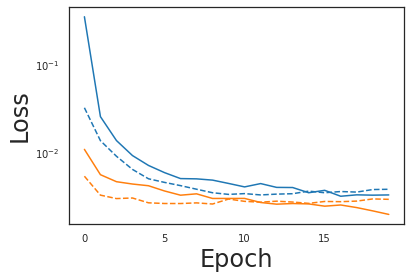

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

#### Training the model

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val))

Epoch 1/100
69/69 [==============================] - 3s 19ms/step - loss: 0.0106 - tp: 101.0000 - fp: 6.0000 - tn: 199013.0000 - fn: 244.0000 - precision: 0.9439 - recall: 0.2928 - prc: 0.3805 - val_loss: 0.0049 - val_tp: 71.0000 - val_fp: 6.0000 - val_tn: 59691.0000 - val_fn: 42.0000 - val_precision: 0.9221 - val_recall: 0.6283 - val_prc: 0.7575
Epoch 2/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0056 - tp: 113.0000 - fp: 30.0000 - tn: 139292.0000 - fn: 119.0000 - precision: 0.7902 - recall: 0.4871 - prc: 0.6125 - val_loss: 0.0033 - val_tp: 80.0000 - val_fp: 5.0000 - val_tn: 59692.0000 - val_fn: 33.0000 - val_precision: 0.9412 - val_recall: 0.7080 - val_prc: 0.8244
Epoch 3/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0050 - tp: 124.0000 - fp: 20.0000 - tn: 139302.0000 - fn: 108.0000 - precision: 0.8611 - recall: 0.5345 - prc: 0.6246 - val_loss: 0.0029 - val_tp: 82.0000 - val_fp: 6.0000 - val_tn: 59691.0000 - val_fn: 31.0000 - val_precision:

#### Plotting the training history

It's useful to plot the training history to identify over or under fitting of the data.

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  fig = plt.figure(figsize=(12, 10))
  plt.suptitle("Training history",fontsize=16)
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch', fontsize=11)
    plt.ylabel(name, fontsize=11)
    
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    #plt.xlim([-1,100])
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(prop={'size': 10});

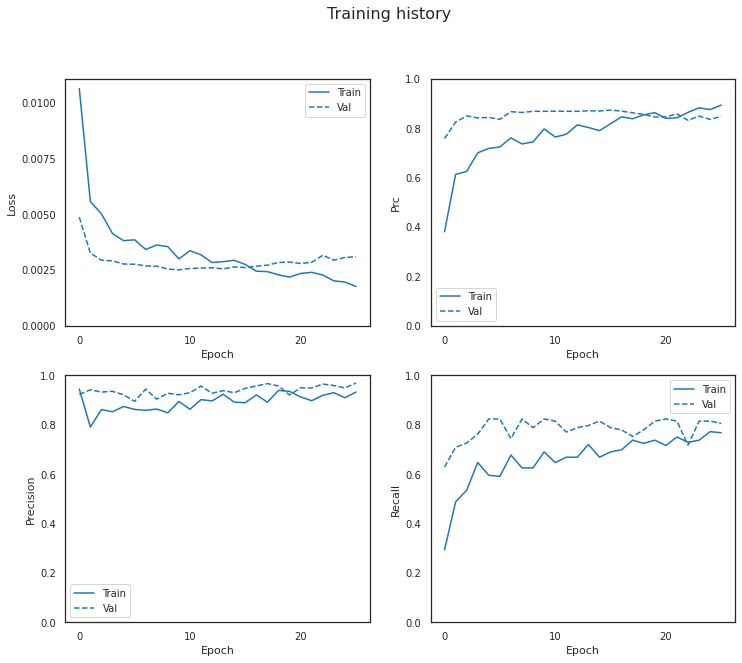

In [ ]:
plot_metrics(baseline_history)

Now let's predict using the trained model

In [ ]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

#### Plot the PRC

Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.


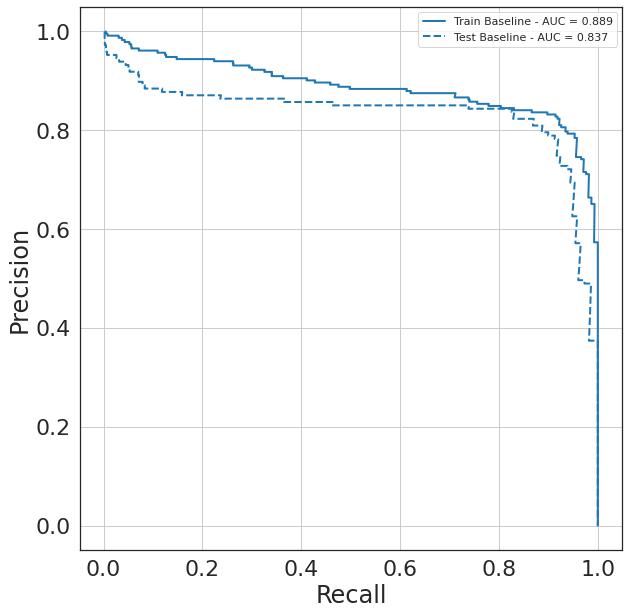

In [ ]:
plt.figure(figsize=(12,10))
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='upper right',prop={'size': 11});

In [ ]:
prc_thr = prc_best_threshold(y_test, test_predictions_baseline)
print("The best threshold for the PRC curve is: ",prc_thr)

The best threshold for the PRC curve is:  0.17985423


#### Evaluate metrics


Evaluate your model on the test dataset using the best threshold and display the results for the metrics selected:

Metrics at 0.17985422909259796 classification threshold
Legitimate Transactions Detected (True Negatives):  85281
Legitimate Transactions Incorrectly Detected (False Positives):  15
Fraudulent Transactions Missed (False Negatives):  29
Fraudulent Transactions Detected (True Positives):  118
Precision:  0.8872180451127819
Recall (Sensitivity):  0.8027210884353742
F2-Score:  0.8183079056865464
PRC AUC Score:  0.8370375083776138
ROC AUC Score:  0.9704764409046304
Total Fraudulent Transactions:  147


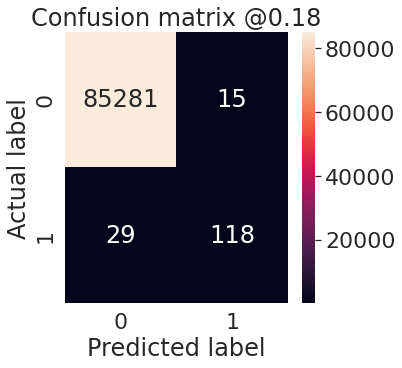

In [ ]:
plot_cm(y_test, test_predictions_baseline, p=prc_thr)

We can see that there is a nice balance between precision and recall, but we want a higher recall to ensure we get as little false negatives as possible (even at the expense of having more false positives). We can also see how the ROC-AUC score tells us this is an amazing model, however when comparing it to the PR AUC we see that it's not as great. 

#### Plot the ROC

Let's repeat this step but using ROC as the metric

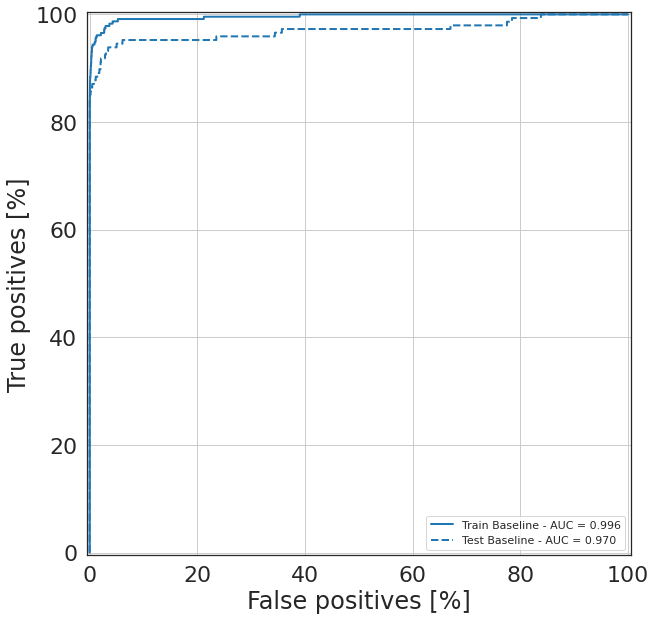

In [ ]:
plt.figure(figsize=(12,10))
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right',prop={'size': 11});

In [ ]:
roc_thr_baseline = roc_best_threshold(y_test, test_predictions_baseline)
print("The best threshold for the ROC curve is: ",roc_thr_baseline)

The best threshold for the ROC curve is:  0.00036109673


This threshold is really low, meaning that it will tend to classify the positive class more often and will lead to a higher FP number. Let's see the metrics using this threshold

Metrics at 0.0003610967251006514 classification threshold
Legitimate Transactions Detected (True Negatives):  82360
Legitimate Transactions Incorrectly Detected (False Positives):  2936
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  137
Precision:  0.04458184184835665
Recall (Sensitivity):  0.9319727891156463
F2-Score:  0.1871073477192024
PRC AUC Score:  0.8370375083776138
ROC AUC Score:  0.9704764409046304
Total Fraudulent Transactions:  147


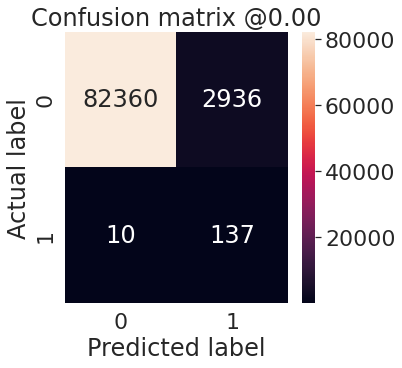

In [ ]:
plot_cm(y_test, test_predictions_baseline, p=roc_thr_baseline)

Clearly, using the ROC curve to analyze the model would lead to wrong conclusions because we get a 98.5% ROC AUC having a model that has a really high FP rate. We should be careful about this, because it could be desirable to have very little FNs. However, this leads to having a lot of FPs which in business terms leads to greater legitimate transactions flags which in turn could lead to customer dissatisfaction with the service the company provides. In the end, it all comes down to business decisions. Nevertheless, we need to make everything in our power to make the best alternative.

We can see how 

## Addressing the class imbalance

### Class weights

The goal of setting class weights is to cause the model to "pay more attention" to examples from an under-represented class.

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### Training the model
Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `tf.keras.optimizers.SGD`, may fail. The optimizer used here, `tf.keras.optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [ ]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
69/69 [==============================] - 3s 19ms/step - loss: 2.0219 - tp: 132.0000 - fp: 1137.0000 - tn: 197882.0000 - fn: 213.0000 - precision: 0.1040 - recall: 0.3826 - prc: 0.2307 - val_loss: 0.1758 - val_tp: 94.0000 - val_fp: 2858.0000 - val_tn: 56839.0000 - val_fn: 19.0000 - val_precision: 0.0318 - val_recall: 0.8319 - val_prc: 0.3356
Epoch 2/100
69/69 [==============================] - 1s 9ms/step - loss: 0.4010 - tp: 188.0000 - fp: 10707.0000 - tn: 128615.0000 - fn: 44.0000 - precision: 0.0173 - recall: 0.8103 - prc: 0.1271 - val_loss: 0.1114 - val_tp: 100.0000 - val_fp: 1430.0000 - val_tn: 58267.0000 - val_fn: 13.0000 - val_precision: 0.0654 - val_recall: 0.8850 - val_prc: 0.4471
Epoch 3/100
69/69 [==============================] - 1s 8ms/step - loss: 0.3026 - tp: 197.0000 - fp: 5875.0000 - tn: 133447.0000 - fn: 35.0000 - precision: 0.0324 - recall: 0.8491 - prc: 0.2667 - val_loss: 0.1083 - val_tp: 102.0000 - val_fp: 1556.0000 - val_tn: 58141.0000 - val_fn: 11.0000

We can now check the training history

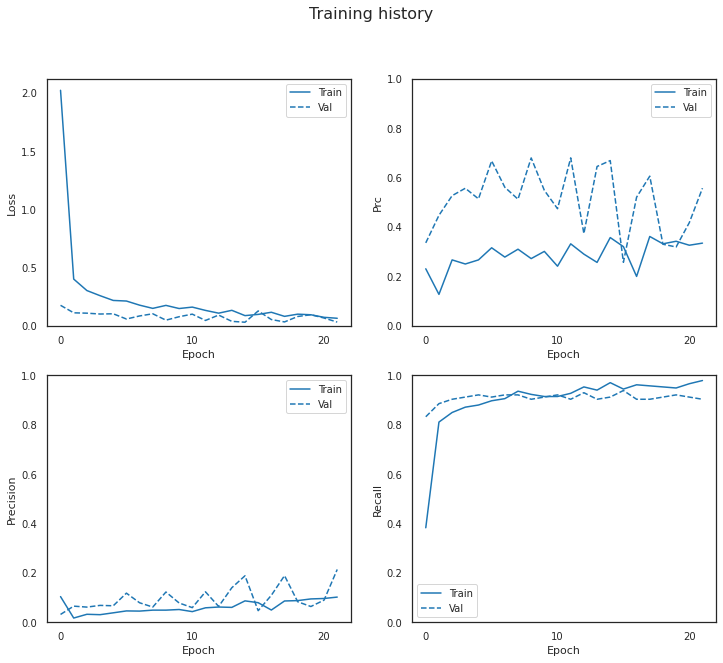

In [ ]:
plot_metrics(weighted_history)

In [ ]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

### Plot the PRC

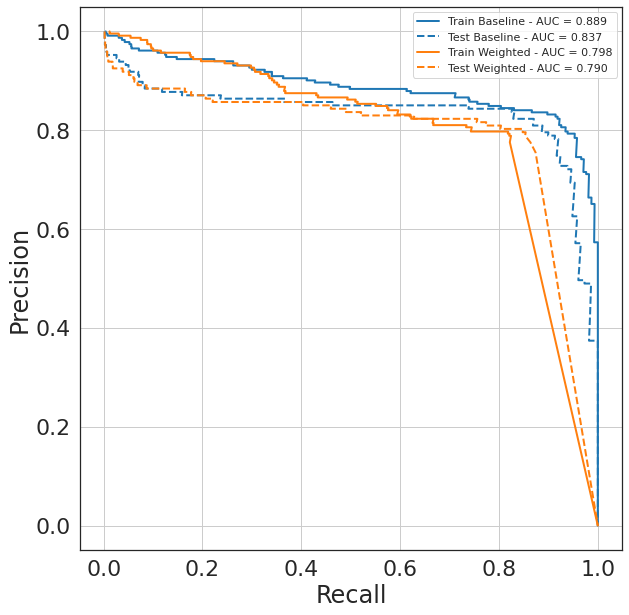

In [ ]:
plt.figure(figsize=(12,10))

plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')
plt.legend(loc='upper right',prop={'size': 11});

In [ ]:
prc_thr_weighted = prc_best_threshold(y_test, test_predictions_weighted)
print("The best threshold for the PRC curve is: ",prc_thr_weighted)

The best threshold for the PRC curve is:  0.9999933


### Evaluate metrics
Evaluate the weighted model on the test dataset and display the results for the metrics you created above:

Metrics at 0.9999933242797852 classification threshold
Legitimate Transactions Detected (True Negatives):  85275
Legitimate Transactions Incorrectly Detected (False Positives):  21
Fraudulent Transactions Missed (False Negatives):  30
Fraudulent Transactions Detected (True Positives):  117
Precision:  0.8478260869565217
Recall (Sensitivity):  0.7959183673469388
F2-Score:  0.805785123966942
PRC AUC Score:  0.7896845199353019
ROC AUC Score:  0.9679944478260258
Total Fraudulent Transactions:  147


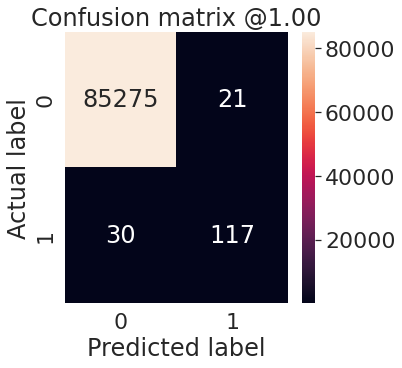

In [ ]:
plot_cm(y_test, test_predictions_weighted, p=prc_thr_weighted)

### Plot the ROC


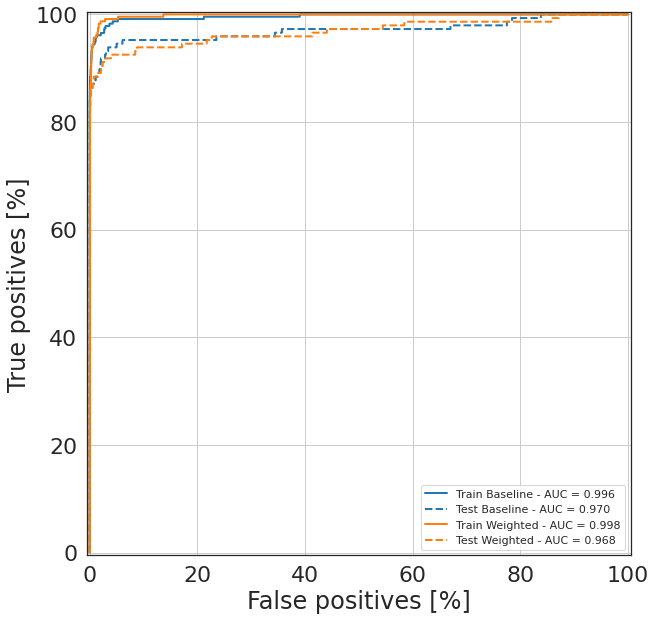

In [ ]:
plt.figure(figsize=(12,10))

plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')
plt.legend(loc='lower right',prop={'size': 11});

In [ ]:
roc_thr_weighted = roc_best_threshold(y_test, test_predictions_weighted)
print("The best threshold for the ROC curve is: ",roc_thr_weighted)

The best threshold for the ROC curve is:  0.21513192


This threshold is really low, meaning that it will tend to classify the positive class more often and will lead to a higher FP number. Let's see the metrics using this threshold

Metrics at 0.21513192355632782 classification threshold
Legitimate Transactions Detected (True Negatives):  82802
Legitimate Transactions Incorrectly Detected (False Positives):  2494
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  134
Precision:  0.05098934550989345
Recall (Sensitivity):  0.9115646258503401
F2-Score:  0.2083333333333333
PRC AUC Score:  0.7896845199353019
ROC AUC Score:  0.9679944478260258
Total Fraudulent Transactions:  147


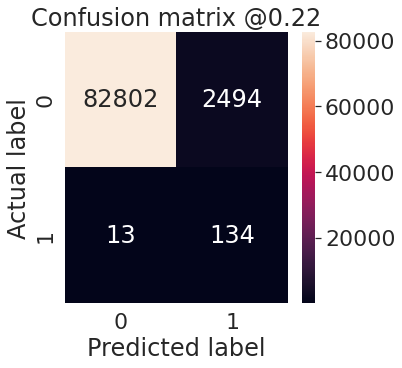

In [ ]:
plot_cm(y_test, test_predictions_weighted, p=roc_thr_weighted)

Again, we can see how ROC is not the best choice to evaluate the model here.

## Oversampling

###  SMOTE

We'll apply SMOTE to oversample the training set. Take special care that the validation and test sets should remain independent to avoid data leakage.

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.3,random_state=0)

In [ ]:
X_train_res, y_train_res = SMOTE().fit_resample(X_train,y_train)

In [ ]:
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
X_train_res = np.clip(X_train_res, -5, 5)
X_val = np.clip(X_val, -5, 5)
X_test = np.clip(X_test, -5, 5)

In [ ]:
y_train_res = np.array(y_train_res)
y_val = np.array(y_val)
y_test = np.array(y_test)

### Training the model


In [ ]:
oversample_model = make_model()
oversample_model.load_weights(initial_weights)

oversample_history = oversample_model.fit(
    X_train_res,
    y_train_res,
    batch_size=128,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val)) 

Epoch 1/100
2177/2177 [==============================] - 17s 7ms/step - loss: 0.1601 - tp: 129744.0000 - fp: 3391.0000 - tn: 195628.0000 - fn: 9691.0000 - precision: 0.9745 - recall: 0.9305 - prc: 0.9846 - val_loss: 0.0702 - val_tp: 99.0000 - val_fp: 1043.0000 - val_tn: 58654.0000 - val_fn: 14.0000 - val_precision: 0.0867 - val_recall: 0.8761 - val_prc: 0.2831
Epoch 2/100
2177/2177 [==============================] - 14s 6ms/step - loss: 0.0321 - tp: 137720.0000 - fp: 807.0000 - tn: 138515.0000 - fn: 1602.0000 - precision: 0.9942 - recall: 0.9885 - prc: 0.9978 - val_loss: 0.0155 - val_tp: 96.0000 - val_fp: 125.0000 - val_tn: 59572.0000 - val_fn: 17.0000 - val_precision: 0.4344 - val_recall: 0.8496 - val_prc: 0.5807
Epoch 3/100
2177/2177 [==============================] - 14s 7ms/step - loss: 0.0210 - tp: 138354.0000 - fp: 508.0000 - tn: 138814.0000 - fn: 968.0000 - precision: 0.9963 - recall: 0.9931 - prc: 0.9985 - val_loss: 0.0141 - val_tp: 96.0000 - val_fp: 116.0000 - val_tn: 59581.00

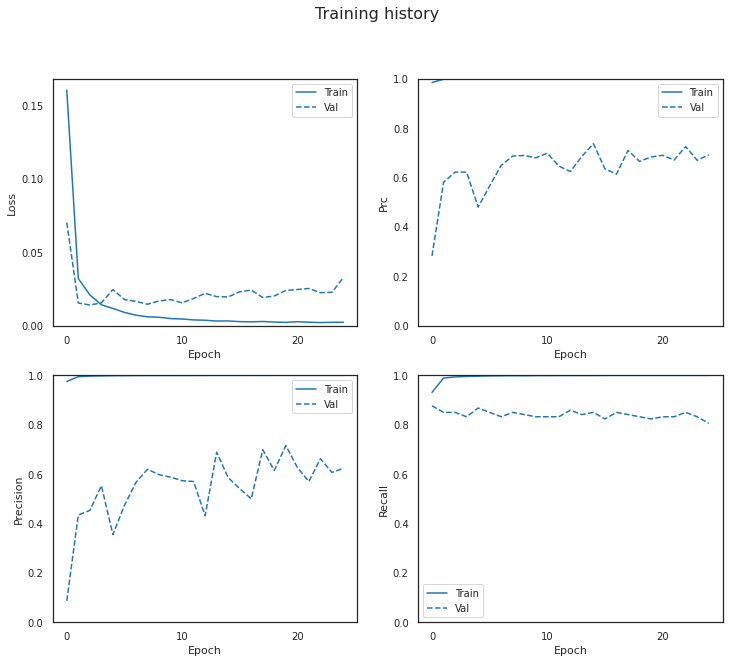

In [ ]:
plot_metrics(oversample_history)

### Plot the PRC

In [ ]:
train_predictions_oversample = oversample_model.predict(X_train_res, batch_size=BATCH_SIZE)
test_predictions_oversample = oversample_model.predict(X_test, batch_size=BATCH_SIZE)

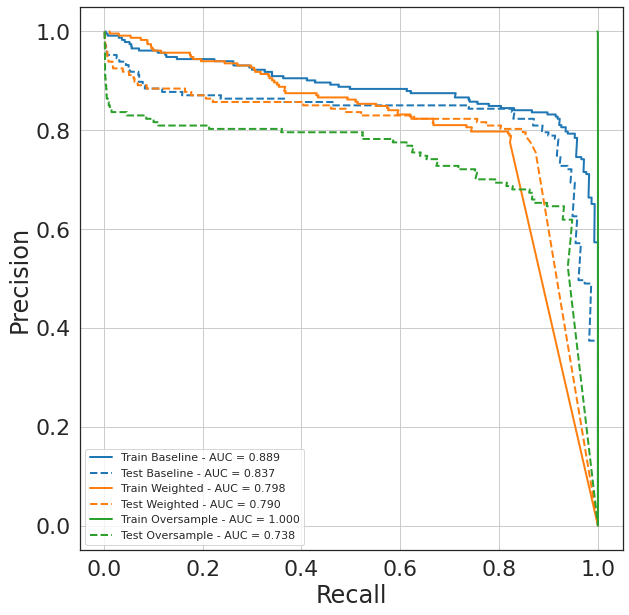

In [ ]:
plt.figure(figsize=(12,10))

plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Oversample", y_train_res, train_predictions_oversample, color=colors[2])
plot_prc("Test Oversample", y_test, test_predictions_oversample, color=colors[2], linestyle='--')
plt.legend(loc='lower left',prop={'size': 11});

In [ ]:
prc_thr_oversample = prc_best_threshold(y_test, test_predictions_oversample)
print("The best threshold for the PRC curve is: ",prc_thr_oversample)

The best threshold for the PRC curve is:  0.9999889


### Evaluate metrics
Evaluate the oversampled model on the test dataset and display the results for the metrics we created above:

Metrics at 0.9999889135360718 classification threshold
Legitimate Transactions Detected (True Negatives):  85289
Legitimate Transactions Incorrectly Detected (False Positives):  7
Fraudulent Transactions Missed (False Negatives):  53
Fraudulent Transactions Detected (True Positives):  94
Precision:  0.9306930693069307
Recall (Sensitivity):  0.6394557823129252
F2-Score:  0.6821480406386068
PRC AUC Score:  0.7382611970290545
ROC AUC Score:  0.9130076599200926
Total Fraudulent Transactions:  147


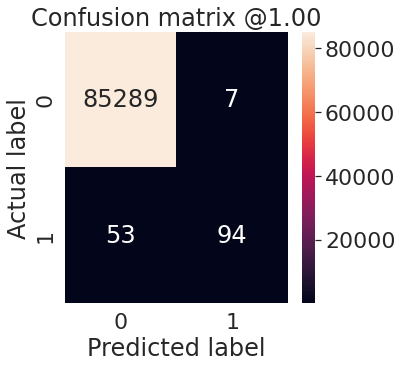

In [ ]:
plot_cm(y_test, test_predictions_oversample, p=prc_thr_oversample)

### Plot the ROC


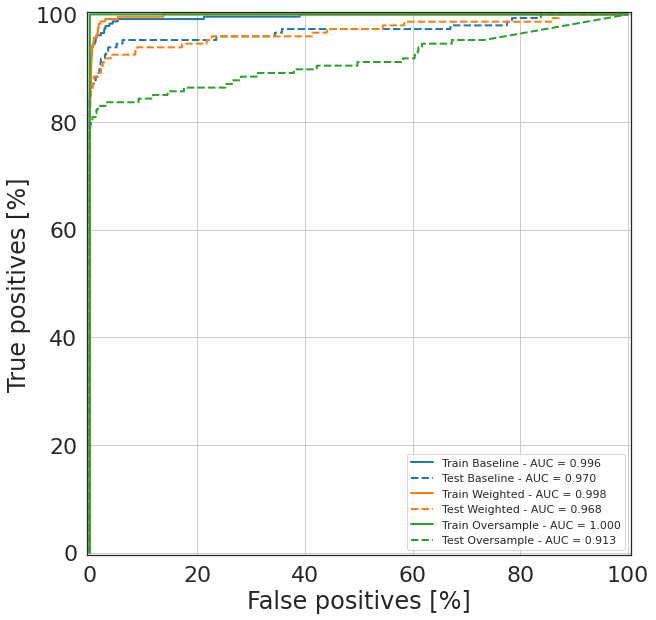

In [ ]:
plt.figure(figsize=(12,10))

plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Oversample", y_train_res, train_predictions_oversample, color=colors[2])
plot_roc("Test Oversample", y_test, test_predictions_oversample, color=colors[2], linestyle='--')
plt.legend(loc='lower right',prop={'size': 11});

In [ ]:
roc_thr_oversample = roc_best_threshold(y_test, test_predictions_oversample)
print("The best threshold for the ROC curve is: ",roc_thr_oversample)

The best threshold for the ROC curve is:  5.230697e-07


This threshold is really low, meaning that it will tend to classify the positive class more often and will lead to a higher FP number. Let's see the metrics using this threshold

Metrics at 5.230696729086048e-07 classification threshold
Legitimate Transactions Detected (True Negatives):  84006
Legitimate Transactions Incorrectly Detected (False Positives):  1290
Fraudulent Transactions Missed (False Negatives):  26
Fraudulent Transactions Detected (True Positives):  121
Precision:  0.08575478384124734
Recall (Sensitivity):  0.8231292517006803
F2-Score:  0.30265132566283137
PRC AUC Score:  0.7382611970290545
ROC AUC Score:  0.9130076599200926
Total Fraudulent Transactions:  147


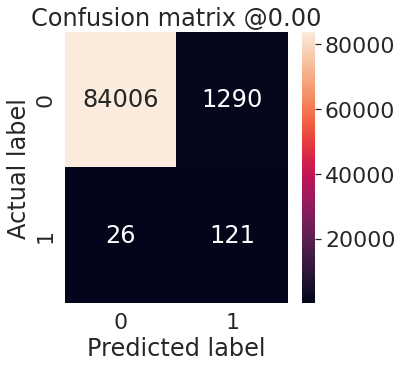

In [ ]:
plot_cm(y_test, test_predictions_oversample, p=roc_thr_oversample)